In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import os
from sklearn.model_selection import train_test_split
import shutil
import hashlib
from collections import defaultdict
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

**seção destinada a DOWNLOAD DO DATASET VIA KAGGLE, NÃO NECESSARIO CASO ELE JÉ ESTEJA SEPARADO EM IMAGES E VALIDATION**

In [ ]:
'''colocar seu kaggle.json (key) caso necessario'''
from google.colab import files
files.upload()

In [ ]:
'''fazer download do dataset'''
import kagglehub

# Download latest version
path = kagglehub.dataset_download("alessandrasala79/ai-vs-human-generated-dataset")

print("Path to dataset files:", path)

**seção destinada a DIVIDIR AS IMAGENS EM SUAS DEVIDAS PASTAS**

In [ ]:
'''criar um df a partir do csv baixado na celula anterior'''
df_train = pd.read_csv('/root/.cache/kagglehub/datasets/alessandrasala79/ai-vs-human-generated-dataset/versions/4/train.csv')

In [ ]:
'''pega 35k de imagens reais e 35k de imagens artificiais (apenas seus nomes, contidos no df)'''
sampled_df = df_train.groupby('label', group_keys=False).apply(lambda x: x.sample(min(len(x), 35000), random_state=42))


In [ ]:
X = sampled_df['file_name']
Y = sampled_df['label']
Y

In [ ]:
'''dividindo o df'''
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.2,random_state=42)
X_train

In [ ]:
import os

os.makedirs("image/IA", exist_ok=True)
os.makedirs("image/HUMAN", exist_ok=True)
os.makedirs("validatio/IA", exist_ok=True)
os.makedirs("validatio/HUMAN", exist_ok=True)


In [ ]:
'''criando os paths, talvez seja necessario fazer a criaçao das pastas images e validation, e IA e HUMAN dentro de images e validation'''
caminho_pasta_nova_ia = '/content/images/IA/'
caminho_pasta_nova_human = '/content/images/HUMAN/'
caminho_pasta_imagens= '/root/.cache/kagglehub/datasets/alessandrasala79/ai-vs-human-generated-dataset/versions/4/train_data/' #ou path onde foi baixado
nome_imagens_df = X_train.values
caminho_teste_ia = '/content/validation/IA/'
caminho_teste_human = '/content/validation/HUMAN/'

In [ ]:
'''limpando o nome do arquivo sem o ";(label)"'''
for arquivo in os.listdir(caminho_pasta_imagens):
    if ';' in arquivo:  # Confere se o arquivo tem o padrão ;1 ou ;0
        nome_imagem = arquivo.split(';')[0]  # Extrai o nome da imagem sem o ;1 ou ;0

        caminho_antigo = os.path.join(caminho_pasta_imagens, arquivo)
        caminho_novo = os.path.join(caminho_pasta_imagens, nome_imagem)

        # renomeia o arquivo
        os.rename(caminho_antigo, caminho_novo)

In [ ]:
'''loop para dividir as imagens de treino de acordo com o label 0 ou 1'''

# Loop sobre cada nome de imagem no DataFrame
for nome_imagem, label in zip(X_train.values, Y_train.values): 
    nome_imagem = nome_imagem[11:]
    caminho_imagem_origem = os.path.join(caminho_pasta_imagens, nome_imagem)
    print(caminho_imagem_origem)
    if label == 1:
        caminho_imagem_destino = os.path.join(caminho_pasta_nova_ia, nome_imagem)
    if label == 0:
        caminho_imagem_destino = os.path.join(caminho_pasta_nova_human, nome_imagem)

    if os.path.exists(caminho_imagem_origem):
        shutil.copy(caminho_imagem_origem, caminho_imagem_destino)
    else:
        print('nao achei')

In [ ]:
'''dividindo as imagens de validação na pasta correta'''

for nome_imagem, label in zip(X_test.values, Y_test.values):  # Supondo que a primeira coluna seja o nome das imagens
    nome_imagem = nome_imagem[11:]
    caminho_imagem_origem = os.path.join(caminho_pasta_imagens, nome_imagem)
    print(caminho_imagem_origem)
    if label == 1:
        caminho_imagem_destino = os.path.join(caminho_teste_ia, nome_imagem)
    if label == 0:
        caminho_imagem_destino = os.path.join(caminho_teste_human, nome_imagem)


    # Mover a imagem se existir
    if os.path.exists(caminho_imagem_origem):
        shutil.copy(caminho_imagem_origem, caminho_imagem_destino)
    else:
        print('nao achei')

**funções adicionais**

In [ ]:
def contar_arquivos(diretorio):
    return len([arquivo for arquivo in os.listdir(diretorio) if os.path.isfile(os.path.join(diretorio, arquivo))])

# Caminho do diretório que você quer contar os arquivos
caminho_diretorio = ''

total_arquivos = contar_arquivos(caminho_diretorio)
print(f"Total de arquivos no diretório: {total_arquivos}")

In [ ]:
'''checa duplicidade'''
def calcular_hash(arquivo, buffer_size=65536):
    sha256 = hashlib.sha256()
    with open(arquivo, 'rb') as f:
        while chunk := f.read(buffer_size):
            sha256.update(chunk)
    return sha256.hexdigest()

def encontrar_arquivos_iguais(diretorio):
    hashes = defaultdict(list)

    for raiz, _, arquivos in os.walk(diretorio):
        for arquivo in arquivos:
            caminho_arquivo = os.path.join(raiz, arquivo)
            hash_arquivo = calcular_hash(caminho_arquivo)
            hashes[hash_arquivo].append(caminho_arquivo)

    # Retornar apenas os arquivos que possuem cópias
    arquivos_duplicados = {hash_: caminhos for hash_, caminhos in hashes.items() if len(caminhos) > 1}

    return arquivos_duplicados

# Caminho do diretório que você quer analisar
caminho_diretorio = ''

duplicados = encontrar_arquivos_iguais(caminho_diretorio)

if duplicados:
    print("Arquivos duplicados encontrados:")
    for hash_, arquivos in duplicados.items():
        print(f"\nHash: {hash_}")
        for arquivo in arquivos:
            print(f" - {arquivo}")
else:
    print("Nenhum arquivo duplicado encontrado.")

In [ ]:
'''comando utilizado no collab para retirar ipynb_checkpoints e evitar problemas com o possivel reconhecimento de ipynb_checkpoints como uma classe'''
!find . -name '.ipynb_checkpoints' -type d -exec rm -rf {} +

**seção destinada a CRIAR OS DATA GENERATORS E DATA AUGMENTATION**

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=[0.8, 1.2],
    horizontal_flip=True,
)

# Treinamento com todos os dados de treino (sem validação)
train_generator = train_datagen.flow_from_directory(
    'images',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

# Carregar imagens de teste (caso tenha um conjunto de teste separado)
test_datagen = ImageDataGenerator(rescale=1./255)

teste_gen = test_datagen.flow_from_directory(
    'validation',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=True
)

In [ ]:
print(teste_gen.class_indices)  # {'classe1': 0, 'classe2': 1}


**CRIAÇÃO DO MODELO**

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model

# Carrega a EfficientNetB0 pré-treinada, sem o topo
base_model = EfficientNetB0(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

# Congela o backbone inicialmente
base_model.trainable = False

# Adiciona o "topo" personalizado
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x)

# Modelo final
model_effnet = Model(inputs=base_model.input, outputs=output)

# compila
model_effnet.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
                     loss='binary_crossentropy',
                     metrics=['accuracy'])

# warm-up
model_effnet.fit(train_generator,
                 epochs=5,
                 validation_data=teste_gen,
                 steps_per_epoch=len(train_generator))

#libera o backbone para fine-tuning completo
base_model.trainable = True

# Recompila com uma taxa de aprendizado menor para evitar desaprender
model_effnet.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
                     loss='binary_crossentropy',
                     metrics=['accuracy'])

# Treina tudo com fine-tuning
model_effnet.fit(train_generator,
                 epochs=10,
                 validation_data=teste_gen,
                 steps_per_epoch=len(train_generator))


In [ ]:
'''salva modelo'''
model_effnet.save('model_effnet.keras')

In [50]:


model = load_model('model_effnet.keras')  # ou .keras se for novo formato


In [52]:
model.predict(img_array)

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


array([[0.01568351]], dtype=float32)

**seção destinada a MÉTRICAS DE AVALIAÇÃO E SAMPLES**

In [ ]:
'''evaluate simples no conjunto de testes'''
model.evaluate(teste_gen)

In [ ]:
'''função para plotar samples de previsão dos testes'''

import matplotlib.pyplot as plt
import numpy as np

def mostrar_amostras_e_previsoes(model, gerador, n_amostras=5, nome_arquivo='previsoes_inteligencia_artificial.png'):
    # Garante que o gerador não esteja embaralhado para pegar imagens sequenciais
    imagens, labels_reais = next(gerador)

    # Sorteia índices aleatórios
    indices = np.random.choice(range(len(imagens)), size=n_amostras, replace=False)

    plt.figure(figsize=(18, 6)) # Aumentei um pouco o tamanho para o texto caber melhor

    for i, idx in enumerate(indices):
        imagem = imagens[idx]
        label_real = labels_reais[idx]
        imagem_expandida = np.expand_dims(imagem, axis=0)
        predicao = model.predict(imagem_expandida, verbose=0)[0][0]

        # Determina a classe real da imagem
        classe_real_texto = "IA" if int(label_real) == 1 else "HUMAN"

        # Formata a porcentagem de chance de ser artificial
        chance_artificial_texto = f"{predicao:.2f}"

        # Adiciona a indicação de incerteza
        if 0.4 <= predicao <= 0.6:
            predicao_texto = f"Predição: Incerto ({chance_artificial_texto})"
        elif 0.6 < predicao:
            predicao_texto = f"Predição: IA ({chance_artificial_texto})"
        else:
            predicao_texto = f"Predição: HUMAN ({chance_artificial_texto})"

        plt.subplot(1, n_amostras, i + 1)
        # Ajuste para garantir que a imagem seja exibida corretamente (0-1 ou 0-255)
        if imagem.max() > 1.0:
            plt.imshow(imagem.astype(np.uint8))
        else:
            plt.imshow(imagem)
        plt.axis('off')
        plt.title(f"Classe Real: {classe_real_texto}\n{predicao_texto}", fontsize=18) # Ajustei o fontsize

    plt.tight_layout()

    # --- Salvar a imagem ---
    plt.savefig(nome_arquivo)

    # Opcional: Mostrar a imagem depois de salvar
    plt.show()

    plt.close() # Fecha a figura para liberar memória

In [ ]:
mostrar_amostras_e_previsoes(model, teste_gen, n_amostras=5)

In [ ]:
"gera duas matrizes de confusão, de plt e sklearn"

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
print("\n--- Gerando Matriz de Confusão ---")


y_true = teste_gen.classes

teste_gen.reset()


predictions_proba = model.predict(teste_gen, verbose=1)


y_pred = (predictions_proba > 0.5).astype(int).flatten()

cm = confusion_matrix(y_true, y_pred)

print("\nMatriz de Confusão Bruta:")
print(cm)


if hasattr(teste_gen, 'class_indices'):
    idx_to_class = {v: k for k, v in teste_gen.class_indices.items()}
    class_names = [idx_to_class[i] for i in sorted(idx_to_class.keys())]
else:
    class_names = ['Classe 0', 'Classe 1']

print(f"\nNomes das Classes: {class_names}")

plt.figure(figsize=(8, 6))
sns.heatmap(cm,
            annot=True,    
            fmt='d',        
            cmap='Blues',   
            xticklabels=class_names, 
            yticklabels=class_names) 

plt.xlabel('Previsão')
plt.ylabel('Verdadeiro')
plt.title('Matriz de Confusão do Modelo EfficientNetB0')
plt.tight_layout()
plt.savefig('matriz_confusao_efficientnet.png')
plt.show() 

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='Blues', values_format='d')
plt.title('Matriz de Confusão (via ConfusionMatrixDisplay)')
plt.savefig('matriz_confusao_efficientnet_display.png')
plt.show()

print("\nMatriz de Confusão gerada e salva como 'matriz_confusao_efficientnet.png' e 'matriz_confusao_efficientnet_display.png'.")

In [ ]:
from sklearn.metrics import classification_report

teste_gen.reset() 
y_true = teste_gen.classes

predictions_proba = model.predict(teste_gen, verbose=1)

y_pred = (predictions_proba > 0.5).astype(int).flatten()

if hasattr(teste_gen, 'class_indices'):
    idx_to_class = {v: k for k, v in teste_gen.class_indices.items()}
    class_names = [idx_to_class[i] for i in sorted(idx_to_class.keys())]
else:
    class_names = ['Classe 0', 'Classe 1'] # Fallback

print("\n--- Relatório de Classificação (Test Set) ---")
print(classification_report(y_true, y_pred, target_names=class_names))

**aplicação prática**

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


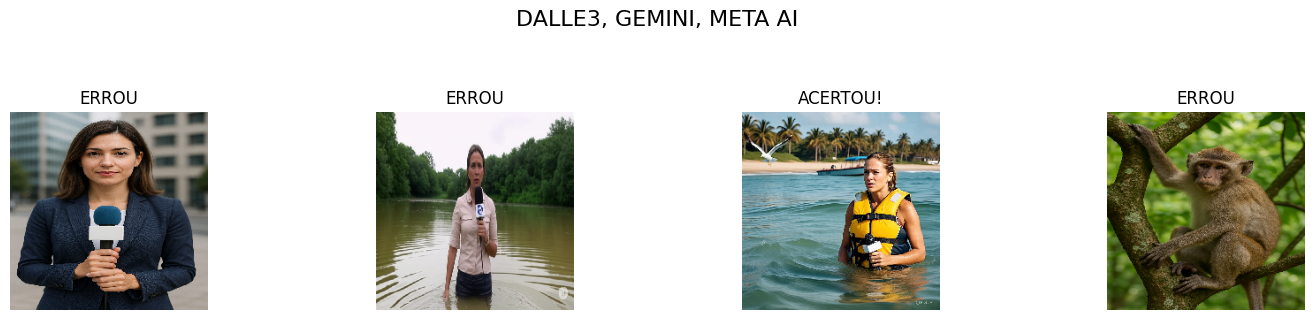

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


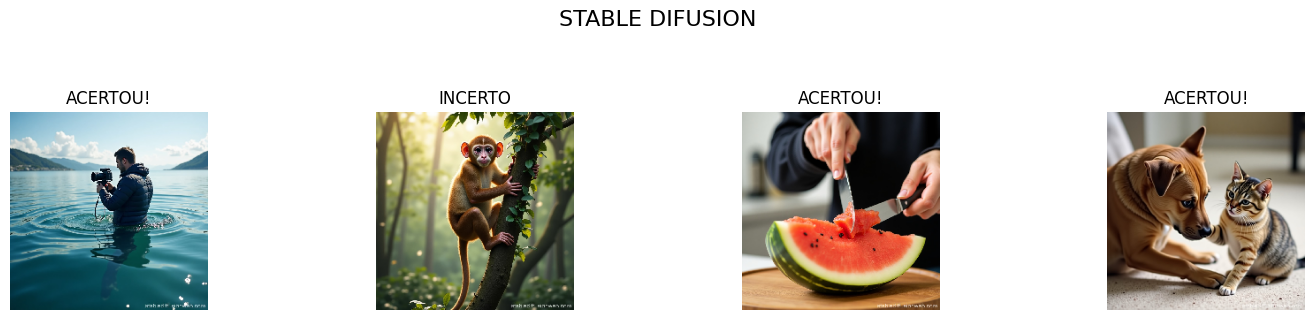

In [72]:
from tensorflow.keras.preprocessing import image
import numpy as np

# Caminho da imagem

img1 = 'gpt1.png'
img2 = 'gpt3.png'
img3 = 'gpt4.jpeg'
img4 = 'gpt5.png'

img5 = 'stb3.jpg'
img6 = 'stb5.jpg'
img7 = 'stb7.jpg'
img7 = 'stb9.jpg'
img_path = 'gpt1.png'

# Carrega a imagem no tamanho que o modelo espera, ex: 224x224
img = image.load_img(img_path, target_size=(224, 224, 3))

# Converte a imagem em array numpy
img_array = image.img_to_array(img)

# Normaliza os pixels (0-1) se o modelo foi treinado assim
img_array = img_array / 255.0

# Expande a dimensão para simular um batch (1, 224, 224, 3)
img_array = np.expand_dims(img_array, axis=0)

from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

model = load_model('model_effnet.keras')  # ou .keras se for novo formato

# Lista de imagens
imgs1 = ['gpt1.png', 'gpt3.png', 'gpt4.jpeg', 'gpt5.png']
imgs2 = ['stb3.jpg','stb5.jpg', 'stb7.jpg', 'stb9.jpg']

def carregar_e_prever(caminho_img):
    img = image.load_img(caminho_img, target_size=(224, 224, 3))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    pred = model.predict(img_array)[0][0]  # Supondo saída com shape (1,1)
    return img, pred

def classificar_previsao(pred):
    if pred > 0.6:
        return "ACERTOU!"
    elif pred > 0.4:
        return "INCERTO"
    else:
        return "ERROU"

def exibir_grid(imagens, titulo):
    plt.figure(figsize=(15, 3))
    for i, path in enumerate(imagens):
        img, pred = carregar_e_prever(path)
        plt.subplot(1, len(imagens), i+1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(classificar_previsao(pred))
    plt.suptitle(titulo, fontsize=16, y=1.05)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


# Exibir grids
exibir_grid(imgs1, 'DALLE3, GEMINI, META AI')
exibir_grid(imgs2, "STABLE DIFUSION")
